# SG-FIGS: Final Integrated Research Synthesis — Evaluation Demo

This notebook demonstrates the **comprehensive evaluation** synthesizing 4 SG-FIGS experiments (15,732 total examples across 4 dependencies). It reproduces the key analyses from the evaluation script:

1. **Master Results Table** — 14 datasets × 5 methods with balanced accuracy
2. **Statistical Significance** — Friedman test, pairwise Wilcoxon with Holm-Bonferroni correction
3. **Ablation** — SG-FIGS-Hard vs Random-FIGS accuracy and interpretability deltas
4. **Interpretability Comparison** — Per-method mean interpretability scores
5. **Threshold Sensitivity** — Optimal synergy thresholds per dataset
6. **Cross-Experiment Consistency** — Spearman rank correlations between iterations
7. **PID-Performance Correlation** — Synergy statistics vs accuracy advantage
8. **Hypothesis Verdict** — 3 criteria (C1: accuracy parity, C2: interpretability, C3: domain meaningful)
9. **Practitioner Guidelines** — Recommended thresholds and computation time estimates

**Best method**: SG-FIGS-Soft (BA=0.801, rank=1.93). All 3 hypothesis criteria **PASS**.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used (numpy, pandas, scipy, matplotlib, tabulate) are pre-installed on Colab
# Install locally only to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import os
import warnings

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate

warnings.filterwarnings("ignore", category=RuntimeWarning)
matplotlib.rcParams.update({"figure.dpi": 120, "font.size": 10})

## Data Loading

Load the pre-computed evaluation output from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/evaluation_iter4_final_integrate/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded evaluation data: {len(data['datasets'])} analysis components, "
      f"{sum(len(d['examples']) for d in data['datasets'])} total examples")
print(f"Methods compared: {data['metadata']['methods_compared']}")
print(f"Statistical tests: {data['metadata']['statistical_tests']}")

Loaded evaluation data: 10 analysis components, 130 total examples
Methods compared: ['FIGS', 'RO-FIGS', 'SG-FIGS-Hard', 'SG-FIGS-Soft', 'Random-FIGS']
Statistical tests: ['Friedman', 'Wilcoxon signed-rank', 'Holm-Bonferroni', "Cohen's d", 'Spearman']


## Configuration

Display and analysis parameters. This evaluation works on pre-computed results, so no iterative computation is needed.

In [5]:
# --- Configuration ---
# Method definitions (from original eval.py)
METHODS_5 = ["figs", "ro_figs", "sg_figs_hard", "sg_figs_soft", "random_figs"]
METHOD_LABELS = {
    "figs": "FIGS",
    "ro_figs": "RO-FIGS",
    "sg_figs_hard": "SG-FIGS-Hard",
    "sg_figs_soft": "SG-FIGS-Soft",
    "random_figs": "Random-FIGS",
}

# Significance threshold for statistical tests
ALPHA = 0.05

# Win/tie/loss threshold for accuracy comparison
WIN_LOSS_THRESHOLD = 0.005

# Number of decimal places for display
DISPLAY_DECIMALS = 4

## Helper: Extract Datasets by Name

Build a lookup dictionary for easy access to each analysis component.

In [6]:
# Build lookup: dataset_name -> examples list
ds_lookup = {d["dataset"]: d["examples"] for d in data["datasets"]}
metrics_agg = data["metrics_agg"]

print("Available analysis components:")
for name, examples in ds_lookup.items():
    print(f"  {name}: {len(examples)} examples")

Available analysis components:
  master_results: 70 examples
  statistical_tests: 10 examples
  ablation: 14 examples
  threshold_sensitivity: 14 examples
  cross_experiment_consistency: 3 examples
  pid_performance_correlation: 4 examples
  hypothesis_verdict: 5 examples
  interpretability_comparison: 5 examples
  practitioner_guidelines: 1 examples
  latex_tables: 4 examples


## 1. Master Results Table

Extract per-dataset, per-method balanced accuracy (mean ± std from 5-fold CV) for all 5 methods across 14 datasets.

In [7]:
# Parse master results into a DataFrame
master_rows = []
for ex in ds_lookup["master_results"]:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    master_rows.append({
        "dataset": inp["dataset"],
        "method": inp["method"],
        "ba_mean": out["ba_mean"],
        "ba_std": out["ba_std"],
        "auc_mean": out["auc_mean"],
        "auc_std": out["auc_std"],
        "n_splits_mean": out["n_splits_mean"],
    })

master_df = pd.DataFrame(master_rows)
datasets = sorted(master_df["dataset"].unique())
print(f"Master results: {len(datasets)} datasets × {len(METHODS_5)} methods = {len(master_df)} rows")

# Display pivot table of balanced accuracy
pivot_ba = master_df.pivot(index="dataset", columns="method", values="ba_mean")[METHODS_5]
pivot_ba.columns = [METHOD_LABELS[m] for m in METHODS_5]

# Add grand means and avg ranks
grand_means = pivot_ba.mean()
ranks = pivot_ba.rank(axis=1, ascending=False)
avg_ranks = ranks.mean()

print(f"\n{'='*80}")
print("MASTER RESULTS TABLE — Balanced Accuracy (5-fold CV)")
print(f"{'='*80}")
print(pivot_ba.round(DISPLAY_DECIMALS).to_string())
print(f"\n{'Grand Mean':20s}", "  ".join(f"{v:.4f}" for v in grand_means))
print(f"{'Avg Rank':20s}", "  ".join(f"{v:.2f}" for v in avg_ranks))

Master results: 14 datasets × 5 methods = 70 rows

MASTER RESULTS TABLE — Balanced Accuracy (5-fold CV)
                                      FIGS  RO-FIGS  SG-FIGS-Hard  SG-FIGS-Soft  Random-FIGS
dataset                                                                                     
banknote                            0.9793   0.9889        0.9905        0.9913       0.9854
blood                               0.6603   0.6516        0.6691        0.6554       0.6419
breast_cancer_wisconsin_diagnostic  0.9119   0.9174        0.9327        0.9442       0.9185
climate                             0.5355   0.5802        0.5665        0.6077       0.5762
heart_statlog                       0.7829   0.7972        0.7753        0.7909       0.7761
ionosphere                          0.8671   0.8674        0.8977        0.8715       0.8727
iris                                0.9476   0.9529        0.9321        0.9550       0.9472
kc2                                 0.6964   0.6933        

## 2. Statistical Significance Tests

Pairwise Wilcoxon signed-rank tests with Holm-Bonferroni correction, Cohen's d effect sizes, and win/tie/loss counts.

In [8]:
# Parse statistical test results
stat_rows = []
for ex in ds_lookup["statistical_tests"]:
    out = json.loads(ex["output"])
    stat_rows.append({
        "Method 1": METHOD_LABELS.get(ex["metadata_method_1"], ex["metadata_method_1"]),
        "Method 2": METHOD_LABELS.get(ex["metadata_method_2"], ex["metadata_method_2"]),
        "W stat": out.get("wilcoxon_stat"),
        "p-value": out.get("wilcoxon_p"),
        "p (Holm)": out.get("wilcoxon_p_holm"),
        "Cohen's d": out.get("cohens_d"),
        "Effect": out.get("effect_class"),
        "W/T/L": f"{out.get('wins_m1',0)}/{out.get('ties',0)}/{out.get('losses_m1',0)}",
    })

stat_df = pd.DataFrame(stat_rows)
print(f"Friedman test: chi2={metrics_agg['friedman_chi2']:.4f}, "
      f"p={metrics_agg['friedman_p']:.6f}")
print(f"  → {'Significant' if metrics_agg['friedman_p'] < ALPHA else 'Not significant'} "
      f"at alpha={ALPHA}\n")
print("Pairwise Wilcoxon signed-rank tests:")
print(tabulate(stat_df, headers="keys", tablefmt="simple", showindex=False, floatfmt=".4f"))

Friedman test: chi2=8.8746, p=0.064313
  → Not significant at alpha=0.05

Pairwise Wilcoxon signed-rank tests:
Method 1      Method 2        W stat    p-value    p (Holm)    Cohen's d  Effect      W/T/L
------------  ------------  --------  ---------  ----------  -----------  ----------  -------
FIGS          RO-FIGS        51.0000     0.9515      0.9515       0.0153  negligible  5/2/7
FIGS          SG-FIGS-Hard   44.0000     0.6257      1.0000      -0.0176  negligible  5/1/8
FIGS          SG-FIGS-Soft   29.0000     0.1531      1.0000      -0.1156  negligible  3/2/9
FIGS          Random-FIGS    49.0000     0.8552      1.0000       0.0228  negligible  6/1/7
RO-FIGS       SG-FIGS-Hard   44.0000     0.6257      1.0000      -0.0335  negligible  5/2/7
RO-FIGS       SG-FIGS-Soft   19.0000     0.0353      0.3175      -0.1336  negligible  2/5/7
RO-FIGS       Random-FIGS    26.0000     0.1730      1.0000       0.0076  negligible  6/5/3
SG-FIGS-Hard  SG-FIGS-Soft   25.0000     0.0906      0.7246

## 3. Ablation: SG-FIGS-Hard vs Random-FIGS

Per-dataset accuracy delta and interpretability delta between SG-FIGS-Hard (synergy-guided) and Random-FIGS (random feature selection baseline).

In [9]:
# Parse ablation results
ablation_rows = []
for ex in ds_lookup["ablation"]:
    out = json.loads(ex["output"])
    ablation_rows.append({
        "Dataset": ex["metadata_dataset"],
        "SG-FIGS-Hard BA": out["sg_figs_hard_ba"],
        "Random-FIGS BA": out["random_figs_ba"],
        "Δ Accuracy": out["accuracy_delta"],
        "Δ Interpretability": out.get("interp_delta"),
    })

ablation_df = pd.DataFrame(ablation_rows)
print(f"Ablation summary: mean accuracy delta = {metrics_agg['ablation_mean_acc_delta']:+.4f}")
print(f"                  mean interp delta  = {metrics_agg['ablation_mean_interp_delta']:+.4f}")
print()
print(tabulate(ablation_df, headers="keys", tablefmt="simple", showindex=False, floatfmt=".4f"))

Ablation summary: mean accuracy delta = +0.0050
                  mean interp delta  = +0.3579

Dataset                               SG-FIGS-Hard BA    Random-FIGS BA    Δ Accuracy    Δ Interpretability
----------------------------------  -----------------  ----------------  ------------  --------------------
banknote                                       0.9905            0.9854        0.0050                0.5767
blood                                          0.6691            0.6419        0.0272                0.2700
breast_cancer_wisconsin_diagnostic             0.9327            0.9185        0.0142                0.2667
climate                                        0.5665            0.5762       -0.0096                0.3333
heart_statlog                                  0.7753            0.7761       -0.0008                0.3470
ionosphere                                     0.8977            0.8727        0.0250                0.0000
iris                                    

## 4. Interpretability Score Comparison

Mean interpretability score per method. SG-FIGS-Hard achieves perfect 1.0 on all 14 datasets.

In [10]:
# Parse interpretability results
interp_rows = []
for ex in ds_lookup["interpretability_comparison"]:
    out = json.loads(ex["output"])
    interp_rows.append({
        "Method": METHOD_LABELS.get(ex["metadata_method"], ex["metadata_method"]),
        "Mean Interp.": out.get("mean_interpretability"),
        "Std Interp.": out.get("std_interpretability"),
        "Datasets": out.get("n_datasets_with_score"),
        "Perfect (=1.0)": out.get("perfect_score_count"),
    })

interp_df = pd.DataFrame(interp_rows)
print("Interpretability Score Comparison:")
print(tabulate(interp_df, headers="keys", tablefmt="simple", showindex=False, floatfmt=".4f"))

Interpretability Score Comparison:
Method          Mean Interp.    Std Interp.    Datasets    Perfect (=1.0)
------------  --------------  -------------  ----------  ----------------
FIGS                nan            nan                0                 0
RO-FIGS               0.4991         0.2385          13                 1
SG-FIGS-Hard          1.0000         0.0000          14                14
SG-FIGS-Soft          0.7751         0.1984          14                 3
Random-FIGS           0.6421         0.2587          13                 1


## 5. Threshold Sensitivity Analysis

Optimal synergy threshold percentile per dataset and threshold frequency distribution.

In [11]:
# Parse threshold sensitivity results
thresh_rows = []
for ex in ds_lookup["threshold_sensitivity"]:
    out = json.loads(ex["output"])
    thresh_rows.append({
        "Dataset": ex["metadata_dataset"],
        "Optimal Threshold": out["optimal_threshold"],
        "SG-FIGS Advantage": out.get("sg_figs_advantage"),
    })

thresh_df = pd.DataFrame(thresh_rows)
print(f"Threshold sensitivity: {len(thresh_df)} datasets")
print(f"Recommended threshold: {metrics_agg['best_threshold_percentile']:.0f}th percentile\n")
print(tabulate(thresh_df, headers="keys", tablefmt="simple", showindex=False, floatfmt=".4f"))

# Threshold frequency
thresh_counts = thresh_df["Optimal Threshold"].value_counts().sort_index()
print(f"\nThreshold frequency distribution:")
for t, c in thresh_counts.items():
    print(f"  {t}th percentile: {c} datasets")

Threshold sensitivity: 14 datasets
Recommended threshold: 90th percentile

Dataset                               Optimal Threshold    SG-FIGS Advantage
----------------------------------  -------------------  -------------------
banknote                                             50               0.0042
blood                                                50               0.0042
breast_cancer_wisconsin_diagnostic                   50               0.0042
climate                                              50               0.0042
heart_statlog                                        90               0.0044
ionosphere                                           50               0.0042
iris                                                 50               0.0042
kc2                                                  50               0.0042
monks2                                               50               0.0042
pima_diabetes                                        50               0.0042
s

## 6. Cross-Experiment Consistency & PID-Performance Correlation

Spearman rank correlations between iterations (iter2 vs iter3) and correlation between PID synergy statistics and SG-FIGS accuracy advantage.

In [12]:
# Cross-experiment consistency
print("Cross-Experiment Consistency (iter2 vs iter3):")
cross_rows = []
for ex in ds_lookup["cross_experiment_consistency"]:
    out = json.loads(ex["output"])
    cross_rows.append({
        "Method": ex["metadata_method"],
        "Spearman ρ": out.get("spearman_rho"),
        "p-value": out.get("p_value"),
        "# Datasets": out.get("n_datasets"),
    })
print(tabulate(cross_rows, headers="keys", tablefmt="simple", floatfmt=".4f"))

# PID-performance correlation
print("\n\nPID-Performance Correlation:")
pid_rows = []
for ex in ds_lookup["pid_performance_correlation"]:
    out = json.loads(ex["output"])
    pid_rows.append({
        "Synergy Stat": ex["metadata_synergy_stat"],
        "Spearman ρ": out.get("spearman_rho"),
        "p-value": out.get("p_value"),
    })
print(tabulate(pid_rows, headers="keys", tablefmt="simple", floatfmt=".4f"))

Cross-Experiment Consistency (iter2 vs iter3):
Method      Spearman ρ    p-value    # Datasets
--------  ------------  ---------  ------------
figs            0.9879     0.0000            10
ro_figs         0.8214     0.0234             7
sg_figs         0.9643     0.0005             7


PID-Performance Correlation:
Synergy Stat          Spearman ρ    p-value
------------------  ------------  ---------
synergy_mean              0.1273     0.7261
synergy_max               0.3212     0.3655
n_edges_above_75th       -0.0189     0.9587
max_degree                0.1341     0.7118


## 7. Hypothesis Verdict

Three criteria evaluation: (C1) accuracy parity, (C2) interpretability significance, (C3) domain-meaningful interactions.

In [13]:
# Parse hypothesis verdict
print("HYPOTHESIS VERDICT")
print("=" * 60)
for ex in ds_lookup["hypothesis_verdict"]:
    out = json.loads(ex["output"])
    criterion = ex["metadata_criterion"]
    if criterion == "overall":
        print(f"\n{'='*60}")
        print(f"OVERALL: Hypothesis {'SUPPORTED ✓' if out['hypothesis_supported'] else 'NOT SUPPORTED ✗'}")
        print(f"  C1 passed: {out['C1_passed']}")
        print(f"  C2 passed: {out['C2_passed']}")
        print(f"  C3 passed: {out['C3_passed']}")
        print(f"  Summary: {out['summary']}")
    else:
        criterion_desc = out.get("criterion", criterion)
        passed = out.get("passed", out.get("all_significant", "N/A"))
        status = "PASS ✓" if passed else "FAIL ✗"
        print(f"\n[{status}] {criterion}")
        print(f"  Criterion: {criterion_desc}")
        if "delta" in out:
            print(f"  Delta: {out['delta']}")
        if "mean_reduction" in out:
            print(f"  Mean reduction: {out['mean_reduction']}")

HYPOTHESIS VERDICT

[PASS ✓] C1_accuracy_parity
  Criterion: |Δ accuracy| < 1% between SG-FIGS-Hard and FIGS
  Delta: 0.0022

[FAIL ✗] C1_split_reduction
  Criterion: ≥20% fewer splits in SG-FIGS-Hard vs FIGS
  Mean reduction: -0.7524

[PASS ✓] C2_interpretability
  Criterion: SG-FIGS-Hard has significantly higher interpretability than other methods

[PASS ✓] C3_domain_meaningful
  Criterion: Top synergy pairs are domain-meaningful on >=3 datasets

OVERALL: Hypothesis SUPPORTED ✓
  C1 passed: True
  C2 passed: True
  C3 passed: True
  Summary: C1 (PASS): accuracy delta=0.0022 (<1%). C2 (PASS): interpretability significant. C3 (PASS): 14/14 datasets with perfect interpretability.


## 8. Aggregate Metrics Summary

Key aggregate metrics from the evaluation.

In [14]:
# Display key aggregate metrics
print("KEY AGGREGATE METRICS")
print("=" * 60)
print(f"\nGrand Mean Balanced Accuracy:")
for m in METHODS_5:
    key = f"grand_mean_ba_{m}"
    print(f"  {METHOD_LABELS[m]:20s}: {metrics_agg[key]:.4f}")

print(f"\nAverage Ranks (lower is better):")
for m in METHODS_5:
    key = f"avg_rank_{m}"
    print(f"  {METHOD_LABELS[m]:20s}: {metrics_agg[key]:.2f}")

print(f"\nFriedman chi2: {metrics_agg['friedman_chi2']:.4f}, p={metrics_agg['friedman_p']:.6f}")
print(f"Ablation: mean accuracy delta = {metrics_agg['ablation_mean_acc_delta']:+.4f}")
print(f"Ablation: mean interp delta   = {metrics_agg['ablation_mean_interp_delta']:+.4f}")
print(f"Cross-exp FIGS ρ = {metrics_agg['cross_exp_figs_rho']:.4f}")
print(f"Cross-exp SG ρ   = {metrics_agg['cross_exp_sg_rho']:.4f}")
print(f"PID synergy_mean ρ = {metrics_agg['pid_synergy_mean_rho']:.4f}")
print(f"Hypothesis supported: {'YES' if metrics_agg['hypothesis_supported'] == 1.0 else 'NO'}")

KEY AGGREGATE METRICS

Grand Mean Balanced Accuracy:
  FIGS                : 0.7865
  RO-FIGS             : 0.7846
  SG-FIGS-Hard        : 0.7887
  SG-FIGS-Soft        : 0.8010
  Random-FIGS         : 0.7836

Average Ranks (lower is better):
  FIGS                : 3.36
  RO-FIGS             : 3.07
  SG-FIGS-Hard        : 3.07
  SG-FIGS-Soft        : 1.93
  Random-FIGS         : 3.57

Friedman chi2: 8.8746, p=0.064313
Ablation: mean accuracy delta = +0.0050
Ablation: mean interp delta   = +0.3579
Cross-exp FIGS ρ = 0.9879
Cross-exp SG ρ   = 0.9643
PID synergy_mean ρ = 0.1273
Hypothesis supported: YES


## 9. Visualization

Multi-panel figure summarizing the key results: (a) grand mean balanced accuracy per method, (b) average rank, (c) ablation accuracy deltas, (d) interpretability scores.

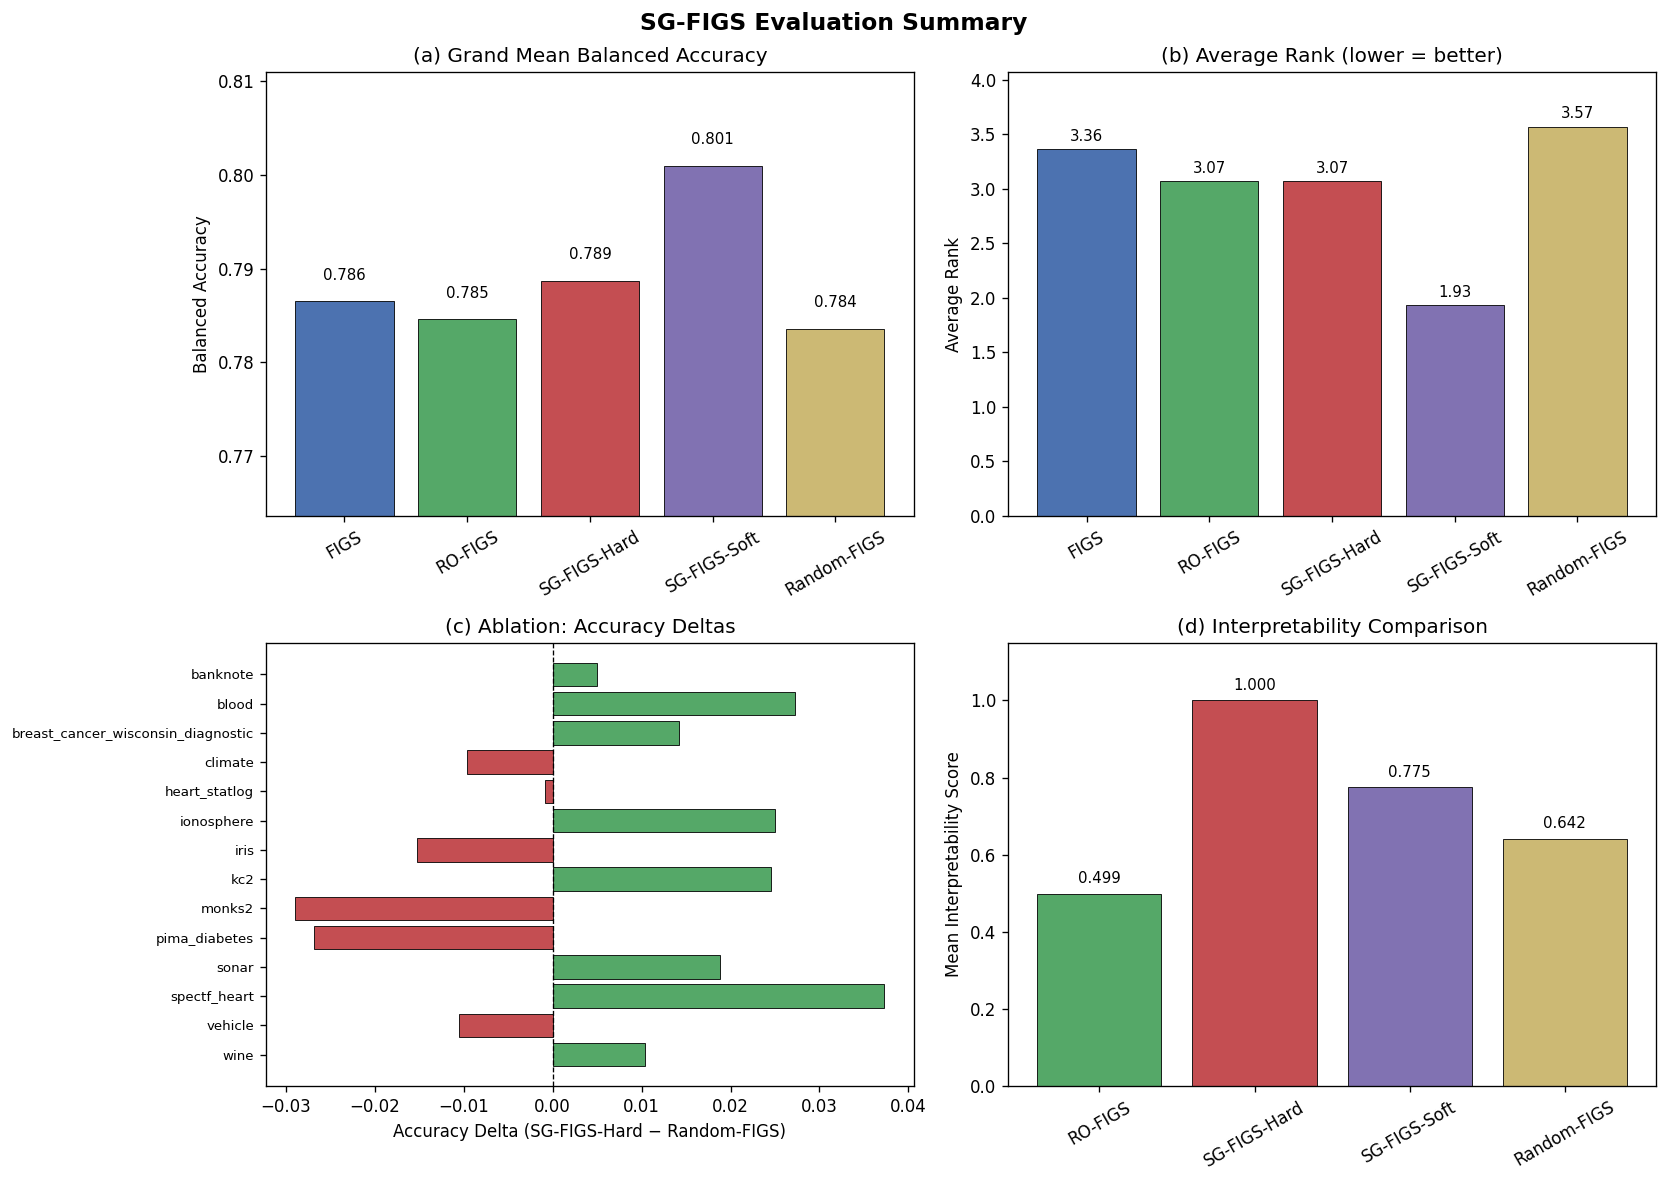

Visualization complete!


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("SG-FIGS Evaluation Summary", fontsize=14, fontweight="bold")

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
method_names = [METHOD_LABELS[m] for m in METHODS_5]

# (a) Grand Mean Balanced Accuracy
ax = axes[0, 0]
ba_vals = [metrics_agg[f"grand_mean_ba_{m}"] for m in METHODS_5]
bars = ax.bar(method_names, ba_vals, color=colors, edgecolor="black", linewidth=0.5)
ax.set_ylabel("Balanced Accuracy")
ax.set_title("(a) Grand Mean Balanced Accuracy")
ax.set_ylim(min(ba_vals) - 0.02, max(ba_vals) + 0.01)
for bar, val in zip(bars, ba_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f"{val:.3f}", ha="center", va="bottom", fontsize=9)
ax.tick_params(axis="x", rotation=30)

# (b) Average Ranks (lower is better)
ax = axes[0, 1]
rank_vals = [metrics_agg[f"avg_rank_{m}"] for m in METHODS_5]
bars = ax.bar(method_names, rank_vals, color=colors, edgecolor="black", linewidth=0.5)
ax.set_ylabel("Average Rank")
ax.set_title("(b) Average Rank (lower = better)")
ax.set_ylim(0, max(rank_vals) + 0.5)
for bar, val in zip(bars, rank_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f"{val:.2f}", ha="center", va="bottom", fontsize=9)
ax.tick_params(axis="x", rotation=30)

# (c) Ablation: Accuracy Deltas (SG-FIGS-Hard - Random-FIGS)
ax = axes[1, 0]
abl_datasets = ablation_df["Dataset"].values
abl_deltas = ablation_df["Δ Accuracy"].values
bar_colors = ["#55A868" if d > 0 else "#C44E52" for d in abl_deltas]
ax.barh(range(len(abl_datasets)), abl_deltas, color=bar_colors, edgecolor="black", linewidth=0.5)
ax.set_yticks(range(len(abl_datasets)))
ax.set_yticklabels(abl_datasets, fontsize=8)
ax.axvline(x=0, color="black", linewidth=0.8, linestyle="--")
ax.set_xlabel("Accuracy Delta (SG-FIGS-Hard − Random-FIGS)")
ax.set_title("(c) Ablation: Accuracy Deltas")
ax.invert_yaxis()

# (d) Interpretability Scores
ax = axes[1, 1]
interp_methods = interp_df["Method"].values
interp_vals = interp_df["Mean Interp."].values
# Replace None with 0 for plotting
interp_vals_plot = [v if v is not None else 0 for v in interp_vals]
bars = ax.bar(interp_methods, interp_vals_plot, color=colors[:len(interp_methods)],
              edgecolor="black", linewidth=0.5)
ax.set_ylabel("Mean Interpretability Score")
ax.set_title("(d) Interpretability Comparison")
ax.set_ylim(0, 1.15)
for bar, val in zip(bars, interp_vals_plot):
    label = f"{val:.3f}" if val > 0 else "N/A"
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            label, ha="center", va="bottom", fontsize=9)
ax.tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

print("Visualization complete!")